In [ ]:
import pandas as pd
from tqdm import tqdm
from rapidfuzz import fuzz

In [139]:
website_df = pd.read_csv("website_data_with_classifications.csv")

KeyboardInterrupt: 

In [ ]:
website_df.head()

,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,...,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,category
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,5651.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,2082.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...",3799.0
3,NaN,NaN,"Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...",...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Home - Regal Ware Work Core Values Story Leade...,Home - Regal Ware Work Core Values Story Leade...,Home - Regal Ware Work Core Values Story Leade...,Home - Regal Ware Work Core Values Story Leade...,5082.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,2369.0


In [ ]:
website_df["category"].count()

4309

In [ ]:
classification_col = website_df["category"]
classification_col = pd.Series([(str(int(x))[:2] if not pd.isnull(x) else "00") for x in classification_col])

In [ ]:
def ngram_text(text):
    text = text.lower()
    return [text[i:i+3] for i in range(0, len(text)-3+1)]


In [ ]:
FUZZY_MODE = False

In [167]:
congresses = [110, 111, 112, 113, 114, 115, 116]
default_values = {}
for congress in congresses:
    phrase_df = pd.read_csv(f"Partisan Index/{congress}_congress_alpha_beta.csv")
    betas = phrase_df["beta"].tolist()
    alphas = phrase_df["alpha"].tolist()

    denominator = 0
    numerator = 0
    for (alpha, beta) in zip(alphas, betas):
        numerator += beta * -alpha
        denominator += beta * beta

    default_values[congress] = numerator / denominator

    print(f"Congress: {congress} ", " Value of Sum(beta_i * -alpha_i) / Sum(beta_i ^ 2): ", numerator/denominator)

Congress: 110   Value of Sum(beta_i * -alpha_i) / Sum(beta_i ^ 2):  0.5429763110878959
Congress: 111   Value of Sum(beta_i * -alpha_i) / Sum(beta_i ^ 2):  0.537753560663196
Congress: 112   Value of Sum(beta_i * -alpha_i) / Sum(beta_i ^ 2):  0.37690607211961086
Congress: 113   Value of Sum(beta_i * -alpha_i) / Sum(beta_i ^ 2):  0.29778211844105384
Congress: 114   Value of Sum(beta_i * -alpha_i) / Sum(beta_i ^ 2):  0.33861337237301475
Congress: 115   Value of Sum(beta_i * -alpha_i) / Sum(beta_i ^ 2):  0.487109637502079
Congress: 116   Value of Sum(beta_i * -alpha_i) / Sum(beta_i ^ 2):  0.43226759882950083


In [185]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from rapidfuzz import fuzz, process
from functools import lru_cache

# session_year_map = {
#     2008: 110,
#     2012: 112,
#     2016: 114,
#     2020: 116
# }
session_year_map = {2007: 110, 2008: 110, 2009: 111, 2010: 111, 2011: 112, 2012: 112, 2013: 113, 2014: 113, 2015: 114, 2016: 114, 2017: 115, 2018: 115, 2019: 116, 2020: 116}
all_website_scores = []
all_website_scores_by_category = {category: [] for category in classification_col.unique()}

sum_year_scores = []
num_websites = []
year_std_devs = []

categorized_normalized_year_scores = {category: [] for category in classification_col.unique()}
categorized_year_std_devs = {category: [] for category in classification_col.unique()}

SIMILARITY_THRESHOLD = 90

@lru_cache(maxsize=100000)
def cached_partial_ratio(phrase, token):
    return fuzz.partial_ratio(phrase, token)

def count_matches(ngrams, phrase):
    curr_index = 0
    count = 0
    while curr_index < len(ngrams):
        if cached_partial_ratio(phrase, ngrams[curr_index]) >= SIMILARITY_THRESHOLD:
            count += 1
            curr_index += 3
        curr_index += 1
    return count

phrase_count_by_year = {}

USE_FILE = True
REMOVE_KEYWORDS = True

removal_keywords = ["credit card", "air force", "new mexico"]

if USE_FILE:
    import pickle
    if FUZZY_MODE:
        phrase_count_by_year = pickle.load(open("phrase_count_by_year_fuzzy.pkl", "rb"))
    else:
        phrase_count_by_year = pickle.load(open("phrase_count_by_year.pkl", "rb"))
    if REMOVE_KEYWORDS:
        for year in phrase_count_by_year:
            for keyword in removal_keywords:
                if keyword in phrase_count_by_year[year].columns:
                    phrase_count_by_year[year].drop(keyword, axis=1, inplace=True)
                else:
                    print("Keyword not found in DataFrame: ", year, keyword)

for year in session_year_map:
    session = session_year_map[year]
    keywords_df = pd.read_csv(f"Partisan Index/{session}_congress_alpha_beta.csv")
    clean_phrases = keywords_df["phrase_clean"]
    clean_phrases = clean_phrases.dropna()
    

    valid_columns = [col for col in website_df.columns if str(year) in col]
    subset = website_df[valid_columns[-1]] # select the last value within a given year

    subset = subset.fillna("")
    subset = subset.astype(str)
    
    subset_split = subset.apply(ngram_text)

    if phrase_count_by_year.get(year) is not None:
        phrase_count = phrase_count_by_year[year]
    else:
        phrase_count = pd.DataFrame(0, index=website_df.index, columns=keywords_df["phrase_clean"])
        for phrase in tqdm(clean_phrases, total=len(clean_phrases)):
            if FUZZY_MODE:
                phrase_count[phrase] = subset_split.apply(lambda x: count_matches(x, phrase))
            else:
                pattern = re.escape(phrase)
                phrase_count[phrase] = subset.apply(lambda x: len(re.findall(pattern, x, re.IGNORECASE)))
        phrase_count_by_year[year] = phrase_count

    y_n_denominator = sum(beta * beta for beta in keywords_df["beta"])

    website_scores = []
    website_scores_by_category = {category: [] for category in classification_col.unique()}

    websites_count = 0
    neutral_website = 0

    for website in tqdm(phrase_count.index):
        website_stats = phrase_count.loc[website]
        valid_phrases = website_stats.index
        website_category = classification_col[website]

        if not subset.loc[website]:
            continue

        phrase_count_sum = website_stats.sum()
        
        if phrase_count_sum == 0:
            website_scores.append(0)
            website_scores_by_category[website_category].append(0)
            continue

        y_n_numerator = 0
        for phrase, beta, alpha in zip(keywords_df["phrase_clean"], keywords_df["beta"], keywords_df["alpha"]):
            if phrase in valid_phrases:
                if phrase_count_sum == 0:
                    y_n_numerator += beta * (0 - alpha)
                else:
                    y_n_numerator += beta * ((website_stats[phrase] / phrase_count_sum) - alpha)
        score = (y_n_numerator / y_n_denominator) - default_values[session]
        website_scores.append(score)
        website_scores_by_category[website_category].append(score)
        websites_count += 1
    all_website_scores.append(website_scores)
    # print("Websites count: ", websites_count, " Number of elements in website_scores: ", len(website_scores))

    sum_year_scores.append(np.sum(website_scores))
    num_websites.append(websites_count)
    year_std_devs.append(np.std(website_scores))

    for category in classification_col.unique():
        if len(website_scores_by_category[category]) == 0:
            # print(f"Category {category} had no websites in year {year}")
            continue
        all_website_scores_by_category[category].append(website_scores_by_category[category])
        categorized_normalized_year_scores[category].append(np.mean(website_scores_by_category[category]))
        categorized_year_std_devs[category].append(np.std(website_scores_by_category[category]))

    print(f"Year {year} score: {np.sum(website_scores) / websites_count}")

Keyword not found in DataFrame:  2011 credit card
Keyword not found in DataFrame:  2011 new mexico
Keyword not found in DataFrame:  2012 credit card
Keyword not found in DataFrame:  2012 new mexico
Keyword not found in DataFrame:  2013 credit card
Keyword not found in DataFrame:  2013 new mexico
Keyword not found in DataFrame:  2014 credit card
Keyword not found in DataFrame:  2014 new mexico
Keyword not found in DataFrame:  2015 credit card
Keyword not found in DataFrame:  2015 air force
Keyword not found in DataFrame:  2015 new mexico
Keyword not found in DataFrame:  2016 credit card
Keyword not found in DataFrame:  2016 air force
Keyword not found in DataFrame:  2016 new mexico
Keyword not found in DataFrame:  2017 credit card
Keyword not found in DataFrame:  2018 credit card
Keyword not found in DataFrame:  2019 credit card
Keyword not found in DataFrame:  2019 air force
Keyword not found in DataFrame:  2019 new mexico
Keyword not found in DataFrame:  2020 credit card
Keyword not f

100%|██████████| 5189/5189 [00:01<00:00, 4413.41it/s]


Year 2007 score: -0.017154147723520197


100%|██████████| 5189/5189 [00:01<00:00, 4399.42it/s]


Year 2008 score: -0.0414209837077096


100%|██████████| 5189/5189 [00:01<00:00, 4344.88it/s]


Year 2009 score: -0.18797675348849743


100%|██████████| 5189/5189 [00:01<00:00, 4049.60it/s]


Year 2010 score: -0.1979564740249999


100%|██████████| 5189/5189 [00:01<00:00, 4363.59it/s]


Year 2011 score: -0.04946938703710094


100%|██████████| 5189/5189 [00:01<00:00, 4178.35it/s]


Year 2012 score: -0.09661947115953583


100%|██████████| 5189/5189 [00:01<00:00, 4244.27it/s]


Year 2013 score: 0.06981271719470196


100%|██████████| 5189/5189 [00:01<00:00, 4110.43it/s]


Year 2014 score: 0.07868305175883702


100%|██████████| 5189/5189 [00:01<00:00, 4023.50it/s]


Year 2015 score: -0.03271804875531883


100%|██████████| 5189/5189 [00:01<00:00, 3792.95it/s]


Year 2016 score: -0.03348719991426297


100%|██████████| 5189/5189 [00:01<00:00, 4013.28it/s]


Year 2017 score: 0.11756726516714079


100%|██████████| 5189/5189 [00:01<00:00, 3915.27it/s]


Year 2018 score: 0.15637337649624133


100%|██████████| 5189/5189 [00:01<00:00, 3647.80it/s]


Year 2019 score: 0.2267950973984637


100%|██████████| 5189/5189 [00:01<00:00, 3429.68it/s]

Year 2020 score: 0.21296907317283126


Number of scores:  2304
Number of scores:  3096
Number of scores:  3942
Number of scores:  4341


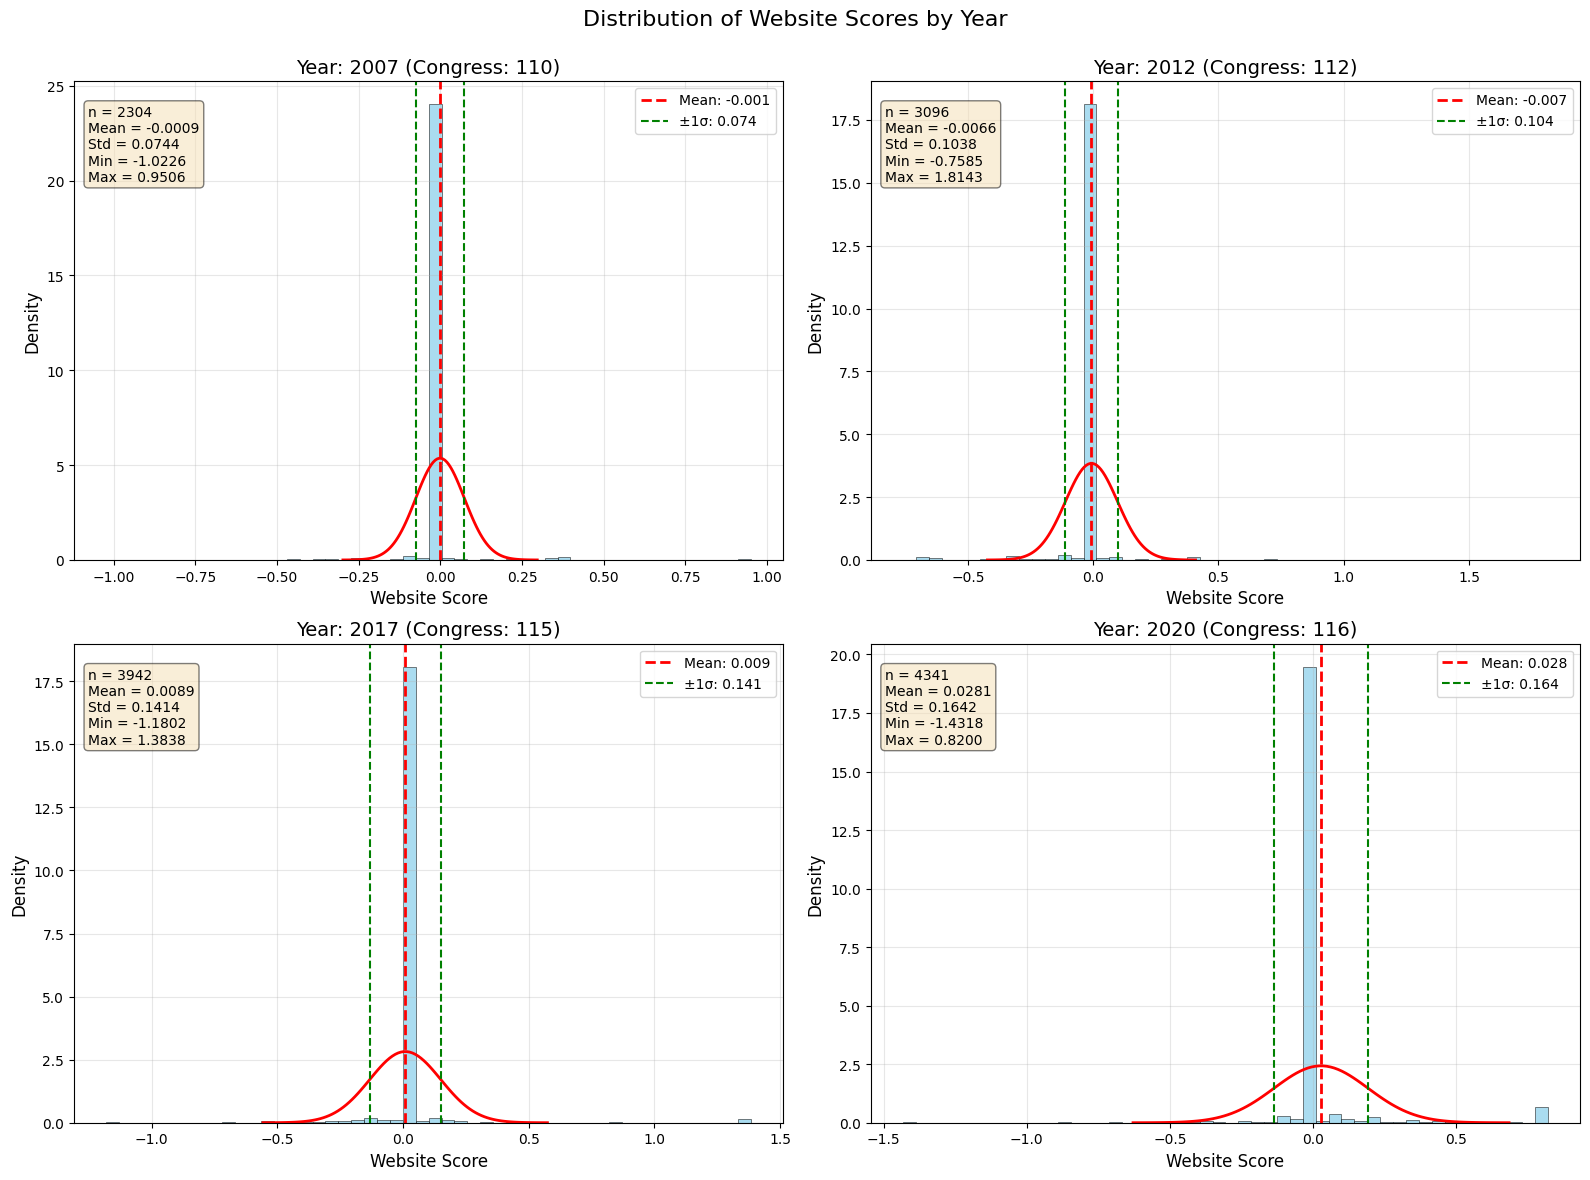

In [186]:
# claude visualization

import numpy as np

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribution of Website Scores by Year', fontsize=16)

# Flatten the axes for easier iteration
axes = axes.flatten()

for i, year_idx in enumerate([0, 5, 10, 13]):  # Sample early, middle, and recent years
    year = list(session_year_map.keys())[year_idx]
    scores = all_website_scores[year_idx]
    print("Number of scores: ", len(scores))
    # scores = scores[:200]
    
    # Calculate statistics
    mean = np.mean(scores)
    std = np.std(scores)
    
    # Plot histogram with density curve
    ax = axes[i]
    n, bins, patches = ax.hist(scores, bins=50, alpha=0.7, density=True, 
                               color='skyblue', edgecolor='black', linewidth=0.5)
    
    # Add normal distribution curve
    x = np.linspace(mean - 4*std, mean + 4*std, 100)
    y = 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2))
    ax.plot(x, y, 'r-', linewidth=2)
    
    # Add vertical lines for mean and standard deviations
    ax.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.3f}')
    ax.axvline(mean + std, color='green', linestyle='dashed', linewidth=1.5, label=f'±1σ: {std:.3f}')
    ax.axvline(mean - std, color='green', linestyle='dashed', linewidth=1.5)
    
    # Add title and labels
    ax.set_title(f'Year: {year} (Congress: {session_year_map[year]})', fontsize=14)
    ax.set_xlabel('Website Score', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Add text with statistics
    text = f'n = {len(scores)}\nMean = {mean:.4f}\nStd = {std:.4f}\nMin = {min(scores):.4f}\nMax = {max(scores):.4f}'
    ax.text(0.02, 0.95, text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [187]:
import numpy as np
print([np.mean(scores) for scores in all_website_scores])
print([np.std(scores) for scores in all_website_scores])

[-0.0008785544407011211, -0.002210479426109297, -0.01399748924612203, -0.016611732086013978, -0.002787242791901436, -0.006553646299580919, 0.004734135433637113, 0.005307983650397735, -0.002902550717034524, -0.003357486274126366, 0.008947280454120304, 0.011890493909616395, 0.026149807050507467, 0.028111328939883048]
[0.07436937689277436, 0.07656773878774426, 0.11705519979613921, 0.124750556552806, 0.09992413387397024, 0.103832664163483, 0.11396536022891623, 0.11758585646049795, 0.0940022199924051, 0.09785538566781198, 0.14136080095814477, 0.1504795436654256, 0.15536707529477892, 0.16418511555496598]


In [188]:
phrase_count_by_year

{2007: phrase_clean  tax increase  natural gas  bush administration  \
 0                        0            0                    0   
 1                        0            0                    0   
 2                        0            0                    0   
 3                        0            0                    0   
 4                        0            0                    0   
 ...                    ...          ...                  ...   
 5184                     0            0                    0   
 5185                     0            0                    0   
 5186                     0            0                    0   
 5187                     0            0                    0   
 5188                     0            0                    0   
 
 phrase_clean  african american  war iraq  raise tax  president bush  \
 0                            0         0          0               0   
 1                            0         0          0               0

In [189]:
phrase_count_by_year[2008].sum(axis=0).sort_values(ascending=False).head(50)

phrase_clean
health care             17
made order              15
renewable energy        15
god bless               12
health insurance        11
civil war               10
student loan             9
consumer product         9
white house              8
solve problem            6
get health               6
power plant              6
natural gas              5
gas price                4
environmentally safe     4
energy efficiency        4
product safety           4
george bush              3
energy cost              3
war cost                 3
economic stimulus        3
higher education         3
war terror               3
homeland security        3
social security          2
fossil fuel              2
health safety            2
global warming           2
family resident          2
iraq afghanistan         2
global war               2
home loan                2
safety system            2
early childhood          2
losing home              2
public service           2
war iraq       

In [177]:
print([np.sum(scores) for scores in all_website_scores])

[1183.5736456091067, 1248.29478613026, 1287.6655073160343, 1357.4720101240077, 1120.405158730555, 1158.4945260230834, 1014.7010214841571, 1080.9515341750518, 1237.4300886239428, 1280.6774848977532, 1863.0361101246822, 1945.0137323466352, 1908.391660678474, 1998.5049254468947]


[-0.0008785544407011211, -0.002210479426109297, -0.01399748924612203, -0.016611732086013978, -0.002787242791901436, -0.006553646299580919, 0.004734135433637113, 0.005307983650397735, -0.002902550717034524, -0.003357486274126366, 0.008947280454120304, 0.011890493909616395, 0.026149807050507467, 0.028111328939883048]


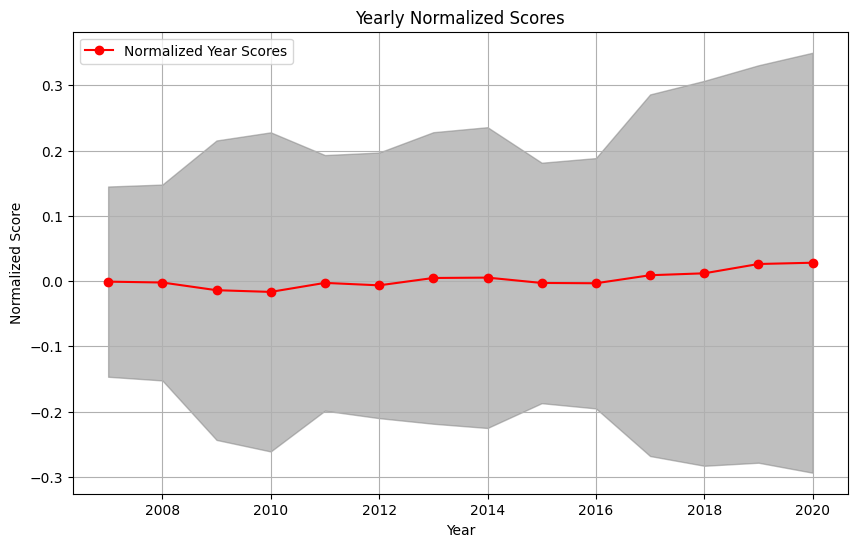

In [192]:
import matplotlib.pyplot as plt

years = list(session_year_map.keys())
normalized_year_scores = [np.mean(scores) for scores in all_website_scores]
# normalized_year_scores = [(score - congress_score) for score, congress_score in zip(normalized_year_scores, [default_values[session_year_map[year]] for year in years])]

mean_of_means = 0

print([(score - mean_of_means) for score in normalized_year_scores])

plt.figure(figsize=(10, 6))
plt.plot(years, [(score - mean_of_means) for score in normalized_year_scores], marker='o', color='r', label='Normalized Year Scores')
plt.fill_between(years, 
                 [score - mean_of_means - 1.96*std for score, std in zip(normalized_year_scores, year_std_devs)], 
                 [score - mean_of_means + 1.96*std for score, std in zip(normalized_year_scores, year_std_devs)], 
                 color='gray', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Normalized Score')
plt.title('Yearly Normalized Scores')
plt.legend()
plt.grid(True)
plt.show()

In [165]:
mean_of_means

0.4451582469578552

In [157]:
import pickle

for year in phrase_count_by_year:
    print("Year: ", year)
    print(phrase_count_by_year[year].sum(axis=0).sort_values(ascending=False).head(15))
    print("\n\n----\n\n")

Year:  2007
phrase_clean
natural gas          20
health care          17
health insurance     14
god bless            12
student loan         11
made order            9
civil war             8
white house           7
consumer product      6
renewable energy      6
get health            5
homeland security     5
health safety         5
solve problem         5
war terror            3
dtype: int64


----


Year:  2008
phrase_clean
health care             17
made order              15
renewable energy        15
god bless               12
health insurance        11
civil war               10
student loan             9
consumer product         9
white house              8
solve problem            6
get health               6
power plant              6
natural gas              5
gas price                4
environmentally safe     4
dtype: int64


----


Year:  2009
phrase_clean
native american      32
rhode island         24
look forward         23
one thing            17
health care         